# The Exact, Algebraic Solution for Error Independent Binary Classifiers

This notebook will illustrate the exact, algebraic solution to error independent binary classifiers that is contained in the `ntqr.r2.ErrorIndependentEvaluation` class. It will be contrasted with another algebraic evaluator the reader may be familiar with - majority voting.

## The polynomial generating set for error-independent binary classification sketches

The observations of agreement and disagreement vote patterns for noisy classification functions are not without structure. This can be seen in the polynomial generating set for three binary classifiers that are arbitrarily correlated. The idea of a "generating set" is that the data sketch of observations is explained by unknown statistics of correctness during a test that we want to estimate. In other words, the aligned decisions of binary classifiers and their resulting counts are not just random numbers. They follow a pattern that is given by the generating set of polynomials. Let's take a peek at that complicated generating set for arbitrarly correlated classifiers.

In [5]:
import sympy
from IPython.display import Math
import ntqr
sympy.init_session()
sympy.init_printing(latex_mode='equation')

IPython console for SymPy 1.13.3 (Python 3.11.8-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.3/



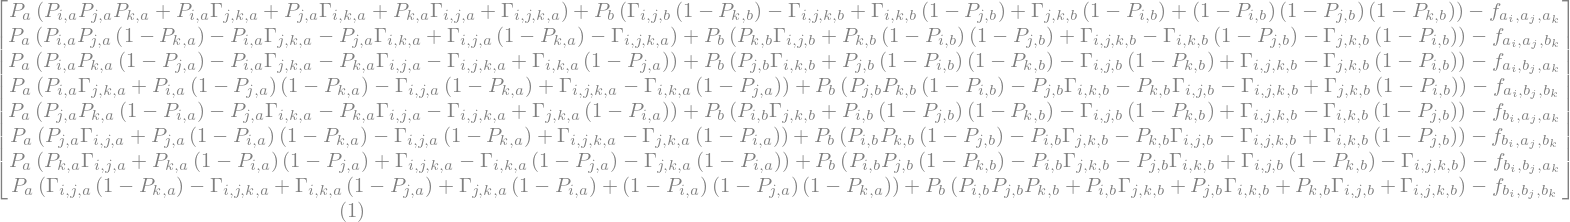

In [6]:
from ntqr.r2.paxioms import (
    trio_binary_classifiers_generating_set,
    pa, pb,
    pia, pib, pja, pjb, pka, pkb,
    gija, gijb, gika, gikb, gjka, gjkb,
    gijka, gijkb)
#from ntqr.r2.datasketches import trio_vote_patterns
Matrix([expr for expr in trio_binary_classifiers_generating_set])

The set above is the one used to derive the axioms of evaluation for binary classification up to N=3. We want to test the error-independent solution so we want the generating set for error-independent binary classifiers. That is given by setting all the error correlations identically to zero.

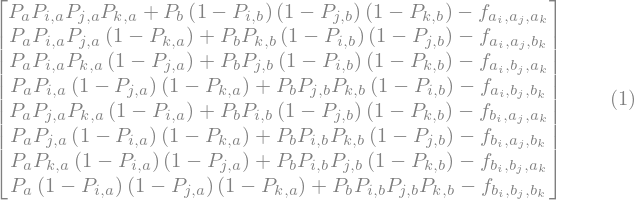

In [8]:
zero_error_correlations = {gija: 0, gijb: 0,
                           gika: 0, gikb: 0,
                           gjka: 0, gjkb: 0,
                           gijka: 0, gijkb: 0}
error_independent_generating_set = [poly.subs(zero_error_correlations) for poly in trio_binary_classifiers_generating_set]
sympy.Matrix(error_independent_generating_set)

The structure of this generating set is the reason we can obtain information about the evaluation using only the observed frequencies that appear at the right. This can be stated precisely by saying that the data sketches of binary classifiers are not generated by eight random integers in an unstructured way as follows.

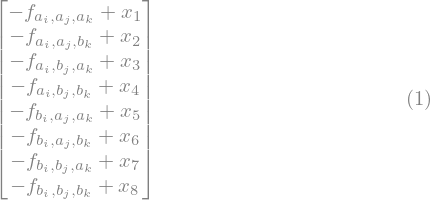

In [10]:
from ntqr.r2.paxioms import trio_frequencies
incorrect_generating_set = [(sympy.Symbol("x_{}".format(i)) - trio_frequencies[i-1]) for i in range(1,9)]
sympy.Matrix(incorrect_generating_set)

Another notebook will discuss the utility of this observation - not every set of vote pattern counts is admissible and therefore we can detect spoofed data sketches.

## A round trip evaluation to demonstrate the exact solution

We can now demonstrate the exact solution for the case of error independent classifiers by using the generating set. We randomly pick values for all the statistics in the generating set, substitute them in the generating set to get the data sketch that would be observed in that case. We then use the data sketch to recover the stastics we used to generate the set.

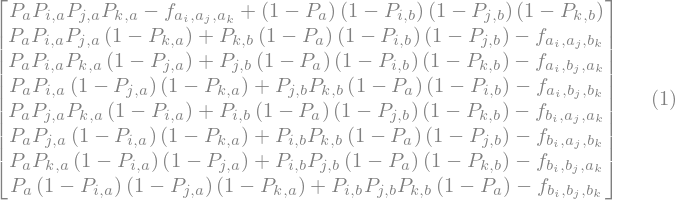

In [14]:
# Let's simplify the substitution by using the relation between pa and pb
simplified_generating_set = [poly.subs({pb:(1-pa)}) for poly in error_independent_generating_set]
sympy.Matrix(simplified_generating_set)

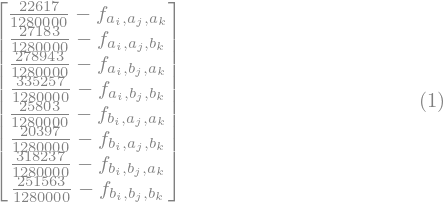

In [15]:
from random import randint
from fractions import Fraction

# We do a random pick for the statistics
simulated_performance_statistics = {var:Fraction(randint(1,39),40) for var in [pa, pia, pib, pja, pjb, pka, pkb]}

# Using the polynomials above, we map the simulated performance statistics to what frequencies of decision
# patterns we would observe.
generated_data_sketch = [poly.subs(simulated_performance_statistics) for poly in simplified_generating_set]
sympy.Matrix(generated_data_sketch)

In [16]:
# Let's turn the voting frequencies back into integer counts
# First, we get the rational fractions.
# SymPy returns solutions wrapped in its own class FiniteSet, so we have to turn them back into lists
# to access the members
data_sketch_frequencies = list(sympy.linsolve(generated_data_sketch, trio_frequencies))[0]
print(data_sketch_frequencies)

(22617/1280000, 27183/1280000, 278943/1280000, 335257/1280000, 25803/1280000, 20397/1280000, 318237/1280000, 251563/1280000)


In [17]:
import math
maxDenominator = math.lcm(*[val.denominator for val in data_sketch_frequencies])
data_sketch_integers = [int(val*maxDenominator) for val in data_sketch_frequencies]
print(data_sketch_integers)

[22617, 27183, 278943, 335257, 25803, 20397, 318237, 251563]


In [18]:
import itertools
trio_decision_patterns = sorted(itertools.product(['a','b'],repeat=3))
trio_vote_patterns = [pattern for pattern in trio_decision_patterns]

In [19]:
# And now we turn them into a data_sketch with their vote patterns
trio_decision_patterns = sorted(itertools.product(['a','b'],repeat=3))
trio_vote_patterns = [pattern for pattern in trio_decision_patterns]
vote_pattern_counts = {trio_vote_patterns[i]: data_sketch_integers[i] for i in range(8)}
vote_pattern_counts

{('a', 'a', 'a'): 22617,
 ('a', 'a', 'b'): 27183,
 ('a', 'b', 'a'): 278943,
 ('a', 'b', 'b'): 335257,
 ('b', 'a', 'a'): 25803,
 ('b', 'a', 'b'): 20397,
 ('b', 'b', 'a'): 318237,
 ('b', 'b', 'b'): 251563}

In [20]:
from ntqr.r2.evaluators import ErrorIndependentEvaluation
from ntqr.r2.datasketches import TrioVoteCounts
tvc = TrioVoteCounts(vote_pattern_counts)
evaluator = ErrorIndependentEvaluation(tvc)
eval_exact = evaluator.evaluation_exact
eval_exact

[{'prevalence': {'a': nan, 'b': nan},
  'accuracy': [{'a': nan, 'b': nan},
   {'a': nan, 'b': nan},
   {'a': nan, 'b': nan}]},
 {'prevalence': {'a': nan, 'b': nan},
  'accuracy': [{'a': nan, 'b': nan},
   {'a': nan, 'b': nan},
   {'a': nan, 'b': nan}]}]

Note how the error independent solution is the best you could possibly do in an unlabeled setting - it returns just two points. In the language of algebraic geometry we would say that the variety (the set of possible solutions) of the error indepedent ideal (the generating set of polynomials) is zero dimensional and consists of two points. One of these two solutions should be an exact match with the random values you got when running this notebook.

In [54]:
simulated_performance_statistics

{P_a: Fraction(13, 40),
 P_{i, a}: Fraction(7, 20),
 P_{i, b}: Fraction(2, 5),
 P_{j, a}: Fraction(3, 40),
 P_{j, b}: Fraction(37, 40),
 P_{k, a}: Fraction(33, 40),
 P_{k, b}: Fraction(13, 20)}

## Majority voting and algebraic evaluators

Majority voting (MV) is usually discussed in the ML/AI literature as a **decision** algorithm. But it can also be used to carry out algebraic evaluation by using those decisions to impute an answer key for the test. Note that this means that the MV algorithm is saying exactly what each item's true label should be. This is to be contrasted with the solution presented here which is **fully** inferential since it never decides what the label of any item on the test should be.

The main problem with MV as an evaluator is that it cannot deal with the **minority report** situation. The crowd is not always right and there are cases where one classifier or two may be badly tuned. We are going to demonstrate that problem by doing a simulation of error independent classifiers that has a 'flipped' classifier.

In [25]:
# Let's pick all the classifiers above 50% performance to start with.
size_test=100
simulated_error_independent_performance = {var:Fraction(randint(0,size_test),size_test) for var in [pia, pib, pja, pjb, pka, pkb]}
# Then let's flip, say, classifiers j,k on the 'a' label below 50% accuracy
simulated_error_independent_performance[pja] = Fraction(randint(0,int(size_test/2)-1),size_test)
simulated_error_independent_performance[pka] = Fraction(randint(0,int(size_test/2)-1),size_test)
# And let's set the 'a' label prevalence to some number below 50%
simulated_error_independent_performance[pa] = Fraction(randint(1,int(size_test/2)-1),size_test)
smeip = simulated_error_independent_performance
print("P_i_a + P_i_b: {}".format(smeip[pia] + smeip[pib]-1))
print("P_j_a + P_j_b: {}".format(smeip[pja] + smeip[pjb]-1))
print("P_k_a + P_k_b: {}".format(smeip[pka] + smeip[pkb]-1))

P_i_a + P_i_b: -2/5
P_j_a + P_j_b: -1/4
P_k_a + P_k_b: -69/100


In [26]:
generated_data_sketch = [poly.subs(simulated_error_independent_performance) for poly in simplified_generating_set]
sympy.Matrix(generated_data_sketch)
data_sketch_frequencies = list(sympy.linsolve(generated_data_sketch, trio_frequencies))[0]
print(data_sketch_frequencies)

(7586919/50000000, 157581/50000000, 12384381/50000000, 271119/50000000, 10531031/50000000, 349469/50000000, 17462669/50000000, 1256831/50000000)


In [27]:
maxDenominator = math.lcm(*[val.denominator for val in data_sketch_frequencies])
data_sketch_integers = [val*maxDenominator for val in data_sketch_frequencies]
print(data_sketch_integers)

[7586919, 157581, 12384381, 271119, 10531031, 349469, 17462669, 1256831]


In [28]:
vote_pattern_counts = {trio_vote_patterns[i]: data_sketch_integers[i] for i in range(8)}
vote_pattern_counts

{('a', 'a', 'a'): 7586919,
 ('a', 'a', 'b'): 157581,
 ('a', 'b', 'a'): 12384381,
 ('a', 'b', 'b'): 271119,
 ('b', 'a', 'a'): 10531031,
 ('b', 'a', 'b'): 349469,
 ('b', 'b', 'a'): 17462669,
 ('b', 'b', 'b'): 1256831}

In [29]:
tvc = TrioVoteCounts(vote_pattern_counts)
evaluator = ErrorIndependentEvaluation(tvc)
eval_exact = evaluator.evaluation_exact
eval_exact

[{'prevalence': {'a': 3/100, 'b': 97/100},
  'accuracy': [{'a': 1/50, 'b': 29/50},
   {'a': 13/100, 'b': 31/50},
   {'a': 29/100, 'b': 1/50}]},
 {'prevalence': {'a': 97/100, 'b': 3/100},
  'accuracy': [{'a': 21/50, 'b': 49/50},
   {'a': 19/50, 'b': 87/100},
   {'a': 49/50, 'b': 71/100}]}]

Note that the error independent algebraic solution correctly picked up that classifier k (3) is actually below 50%. What does majority voting say?

In [31]:
from ntqr.r2.evaluators import MajorityVotingEvaluation
mv_estimate = MajorityVotingEvaluation(tvc)

How does the MV evaluation do?

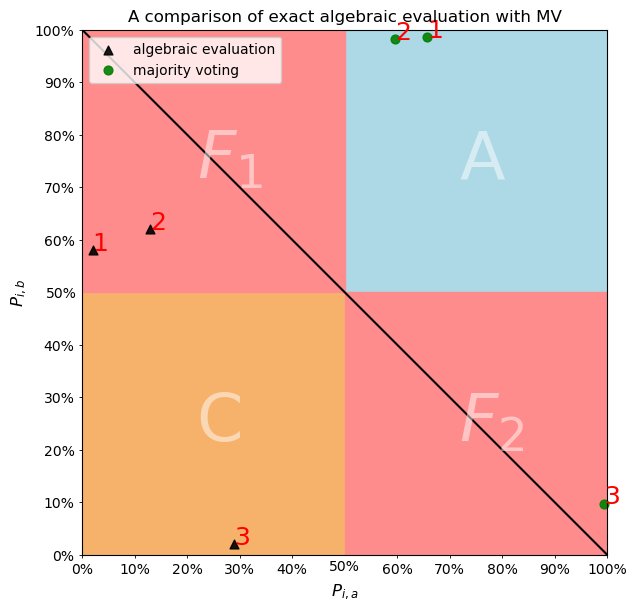

In [33]:
%matplotlib inline
from ntqr.r2.plots import plot_evaluations
mv_exact = mv_estimate.evaluation_exact
size=40
plot_evaluations([
    ["algebraic evaluation",[d['a']*100 for d in eval_exact[0]["accuracy"]],
    [d['b']*100 for d in eval_exact[0]["accuracy"]],
    "^", "k",size],
    ["majority voting",[d['a']*100 for d in mv_exact[0]["accuracy"]],
    [d['b']*100 for d in mv_exact[0]["accuracy"]],
    "o", "g",size]],"A comparison of exact algebraic evaluation with MV",figsize=(7,6),legend_loc="best")

This figure encapsulates the huge advantage of algebraic evaluation over majority voting when it comes to the problem of AI safety. When things are going well, monitoring is useful but not critical. The most important reason for monitoring is the detection of misaligned or malfunctioning algorithms. We see in the figure above that MV thinks that all is well with classifier 2.